# MNIST

In [2]:
import pandas as pd
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/Users/gastonamestoy/.local/share/virtualenvs/handson-ml3-mrfbh5Xn/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist.data, mnist.target
X.shape


(70000, 784)

In [4]:
y.shape


(70000,)

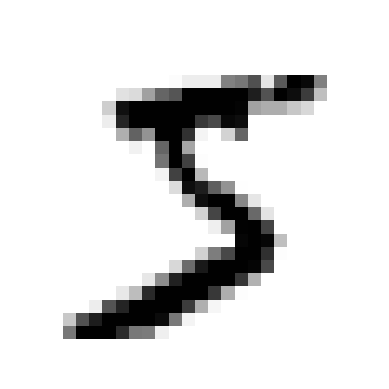

In [5]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()


In [6]:
y[0]


'5'

In [7]:
#The MNIST dataset returned by fetch_openml() is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


# Training a Binary Classifier

In [8]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')


In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])


array([ True])

# Performance Measures
## Measuring Accuracy Using Cross-Validation

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))


False


In [13]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# The first model performance is not that different from the dummy performance.


array([0.90965, 0.90965, 0.90965])

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM).

### Implementing cross validation

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is
# not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


## Confusion Matrices
The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm
# true negatives, false positives
# false negatives, true positives


array([[53892,   687],
       [ 1891,  3530]])

## Precision and Recall

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.
It is often convenient to combine precision and recall into a single metric called the F1 score, especially when you need a single metric to compare two classifiers.

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.


## The Precision/Recall Trade-off


In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([False])

How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

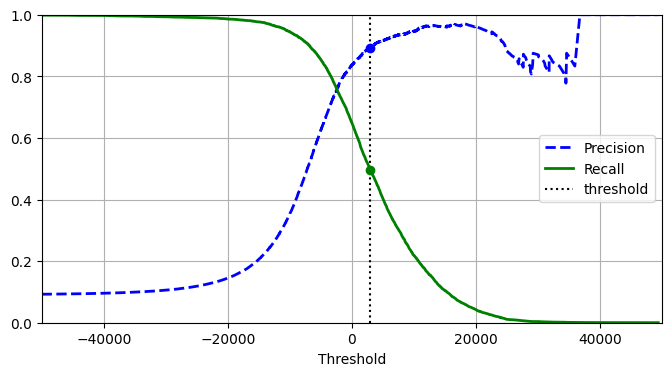

In [23]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

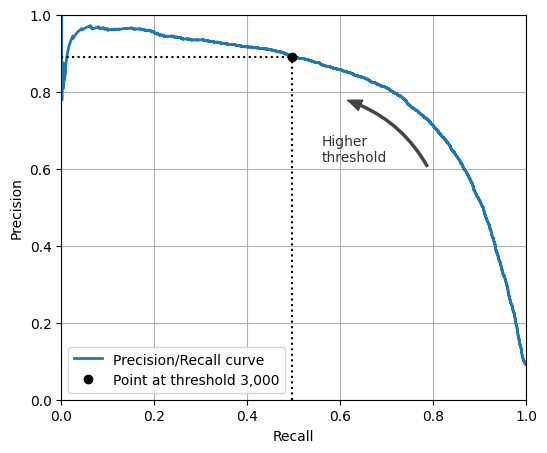

In [24]:

import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()


In [25]:
# If I want to get the threshold that gives me at least 90% precision.
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision


3370.0194991439566

In [26]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)


In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [28]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision


0.4799852425751706

## The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR (also called the fall-out) is the ratio of negative instances that are incorrectly classified as positive.
It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


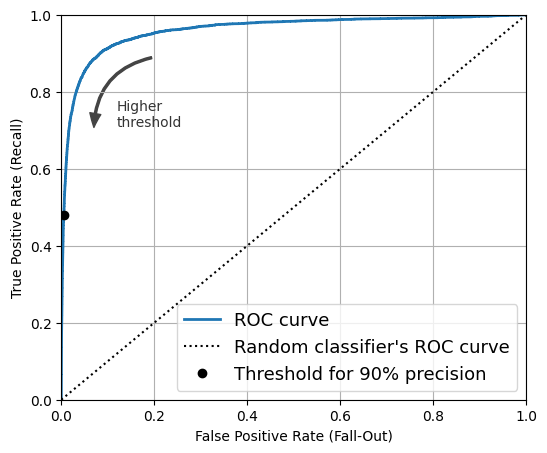

In [30]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()


One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to estimate the ROC AUC:

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.9604938554008616

Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives.
For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement: the curve could really be closer to the top-right corner


In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)


In [33]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")


In [34]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)


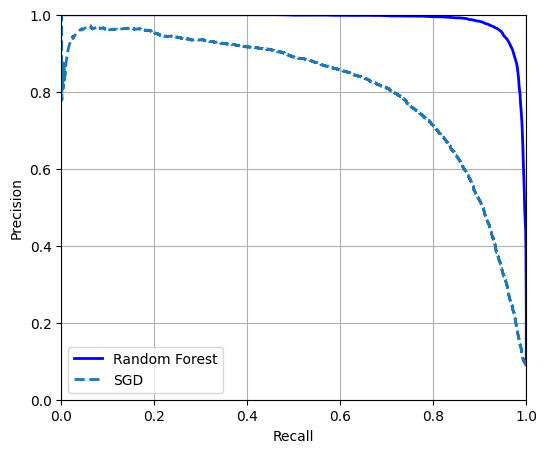

In [35]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()


In [36]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)


0.9274509803921569

In [37]:
roc_auc_score(y_train_5, y_scores_forest)


0.9983436731328145

In [38]:

precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest)


(0.9897468089558485, 0.8725327430363402)

# Multiclass Classification
Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy, or sometimes one-versus-all (OvA).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm.


In [39]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])


SVC(random_state=42)

In [40]:
svm_clf.predict([some_digit])


array(['5'], dtype=object)

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [42]:
class_id = some_digit_scores.argmax()
class_id

5

In [43]:
svm_clf.classes_, svm_clf.classes_[class_id]


(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object), '5')

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes.


In [44]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])


OneVsRestClassifier(estimator=SVC(random_state=42))

In [45]:
ovr_clf.predict([some_digit])


array(['5'], dtype='<U1')

In [46]:
len(ovr_clf.estimators_)


10

In [47]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
# Prediction failed
sgd_clf.predict([some_digit])


array(['3'], dtype='<U1')

In [48]:
sgd_clf.decision_function([some_digit]).round()


array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [49]:
# > 85% of accuracy
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


array([0.87365, 0.85835, 0.8689 ])

In [50]:
from sklearn.preprocessing import StandardScaler
# Scaling the inputs can improve it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

# Error Analysis
This confusion matrix looks pretty good: most images are on the main diagonal, which means that they were classified correctly.

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

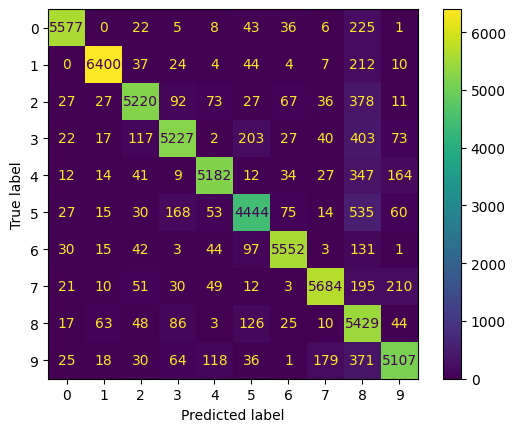

In [52]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

We can normalize the confusion matrix by dividing each value by the total number of images in the corresponding (true) class.


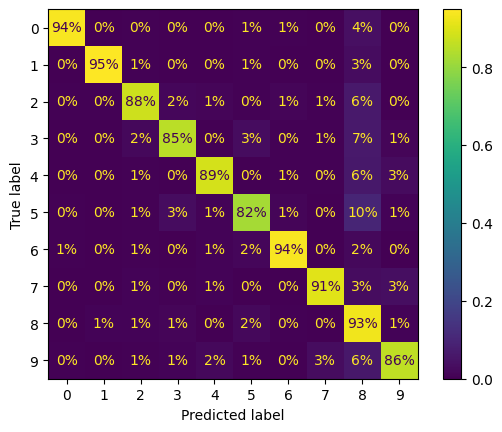

In [53]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()


If you want to make the errors stand out more, you can try putting zero weight on the correct predictions.

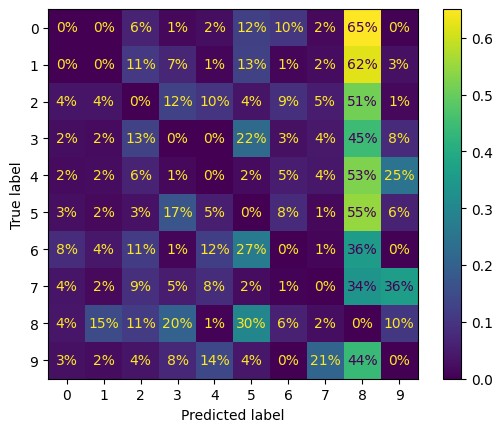

In [54]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()


Be careful how you interpret the percentages in this diagram: remember that we’ve excluded the correct predictions. For example, the 36% in row #7, column #9 does not mean that 36% of all images of 7s were misclassified as 9s. It means that 36% of the errors the model made on images of 7s were misclassifications as 9s.


It is also possible to normalize the confusion matrix by column rather than by row: if you set normalize="pred", you can see that 56% of misclassified 7s are actually 9s.

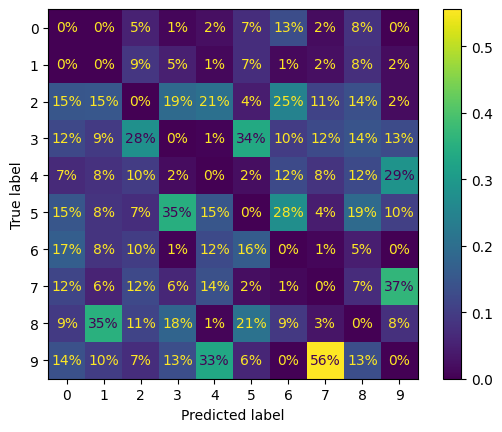

In [55]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
plt.show()


In [56]:

cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

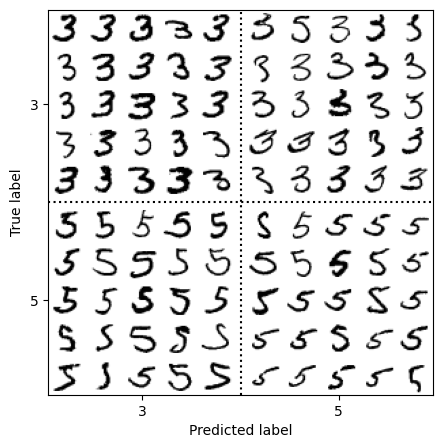

In [57]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


# Multilabel Classification
 In some cases you may want your classifier to output multiple classes for each instance.

In [58]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Two classifications: large (> 6) and odd.
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier()

In [59]:
# The digit (5) is not large and is odd.
knn_clf.predict([some_digit])


array([[False,  True]])

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score.

In [60]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")


0.976410265560605

This approach assumes that all labels are equally important, which may not be the case. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" when calling the f1_score() function.


If you wish to use a classifier that does not natively support multilabel classification, such as SVC, one possible strategy is to train one model per label. However, this strategy may have a hard time capturing the dependencies between the labels. For example, a large digit (7, 8, or 9) is twice more likely to be odd than even, but the classifier for the “odd” label does not know what the classifier for the “large” label predicted. To solve this issue, the models can be organized in a chain: when a model makes a prediction, it uses the input features plus all the predictions of the models that come before it in the chain.


In [61]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [62]:
chain_clf.predict([some_digit])


array([[0., 1.]])

# Multioutput Classification
The last type of classification task we’ll discuss here is called multioutput–multiclass classification (or just multioutput classification). It is a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).
Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPy’s randint() function.

In [63]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


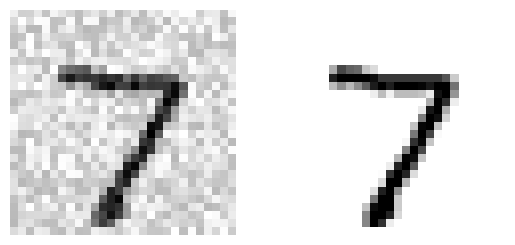

In [64]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()


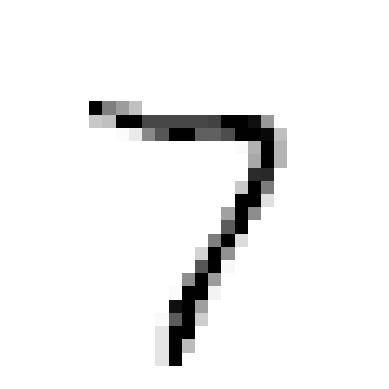

In [65]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()


# Exercises
## Exercise 1


In [66]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

In [91]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights': ['uniform','distance'],
     'n_neighbors': [2,3,4,5,6]},
]
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train[:20000], y_train[:20000])


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [92]:
grid_search.best_params_, grid_search.best_score_


({'n_neighbors': 4, 'weights': 'distance'}, 0.9567)

In [94]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

## Exercise 2


In [70]:
from scipy.ndimage import shift


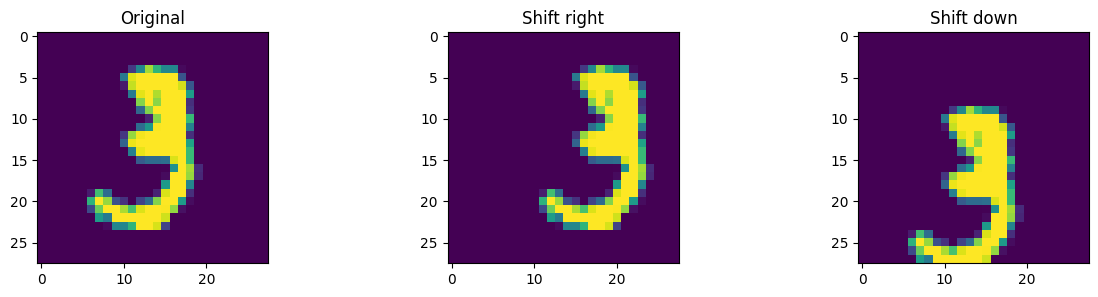

In [71]:
image = X_train[10]

plt.figure(figsize=(15,3))

plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28,28))

plt.subplot(132)
plt.title("Shift right")
plt.imshow(shift(image.reshape(28,28), [0,5], cval=0, mode='constant'))

plt.subplot(133)
plt.title("Shift down")
plt.imshow(shift(image.reshape(28,28), [5,0], cval=0, mode='constant'))

plt.show()


In [75]:
def shift_image(image, x, y):
  return shift(image.reshape(28,28), [y,x], cval=0, mode='constant').reshape([-1])


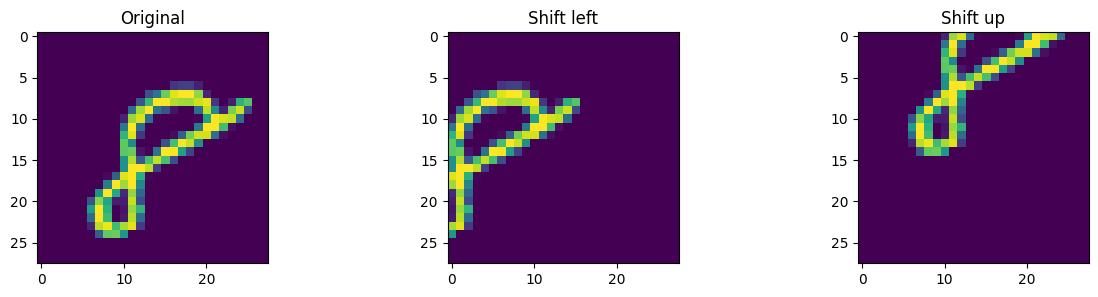

In [77]:
plt.figure(figsize=(15,3))

plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28,28))

plt.subplot(132)
plt.title("Shift left")
plt.imshow(shift_image(image, -10, 0).reshape(28,28))

plt.subplot(133)
plt.title("Shift up")
plt.imshow(shift_image(image, 0, -10).reshape(28,28))

plt.show()


In [78]:
X_train_transformed = [image for image in X_train]
y_train_transformed = [label for label in y_train]

for x, y in ((-1,0),(1,0),(0,-1),(0,1)):
  for image, label in zip(X_train, y_train):
    X_train_transformed.append(shift_image(image, x, y))
    y_train_transformed.append(label)

X_train_transformed = np.array(X_train_transformed)
y_train_transformed = np.array(y_train_transformed)

In [79]:
# The shifted images are grouped, we need to shuffle them
shuffle_idx = np.random.permutation(len(X_train_transformed))

X_train_transformed = X_train_transformed[shuffle_idx]
y_train_transformed = y_train_transformed[shuffle_idx]


In [87]:
knn_clf = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], weights=grid_search.best_params_['weights'])

knn_clf.fit(X_train_transformed, y_train_transformed)


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [88]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy


0.9763

In [95]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")


error_rate_change = -17%


# Exercise 3


In [97]:
train_data = pd.read_csv('./datasets/titanic/train.csv')
test_data = pd.read_csv('./datasets/titanic/test.csv')


In [98]:
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [99]:
train_data.columns= train_data.columns.str.lower()
train_data = train_data.set_index('passengerid')
train_data.head()


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [120]:
test_data.columns= test_data.columns.str.lower()
test_data = test_data.set_index('passengerid')
test_data.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [100]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


cabin has a lot of missing values, name and ticket are too heterogenous. I won't use them.

In [123]:
num_columns = ['age','sibsp','parch','fare']
cat_columns = ['pclass', 'sex', 'embarked']
columns = num_columns + cat_columns

In [124]:
train_data[columns].describe()


,age,sibsp,parch,fare,pclass
count,714.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699113,0.523008,0.381594,32.204208,2.308642
std,14.526507,1.102743,0.806057,49.693429,0.836071
min,0.416700,0.000000,0.000000,0.000000,1.000000
25%,20.125000,0.000000,0.000000,7.910400,2.000000
50%,28.000000,0.000000,0.000000,14.454200,3.000000
75%,38.000000,1.000000,0.000000,31.000000,3.000000
max,80.000000,8.000000,6.000000,512.329200,3.000000


In [125]:
train_data.survived.value_counts()


0    549
1    342
Name: survived, dtype: int64

In [126]:
y_train = train_data.survived


In [127]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns),
])


In [128]:
X_train = preprocess_pipeline.fit_transform(train_data)


/Users/gastonamestoy/.local/share/virtualenvs/handson-ml3-mrfbh5Xn/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [135]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [136]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

In [137]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()


0.8137578027465668

In [138]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()


0.8249313358302123

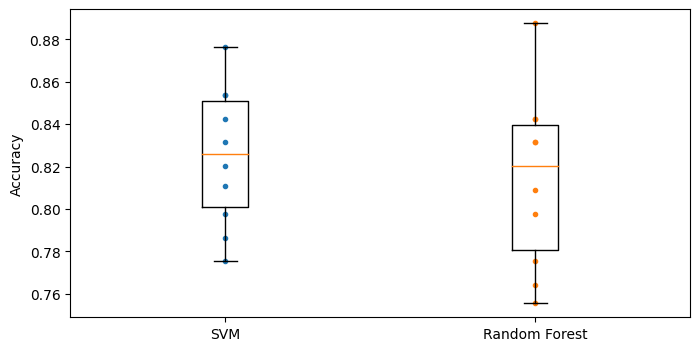

In [139]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()


In [150]:
train_data['agebucket'] = train_data.age // 15 * 15
train_data[['agebucket','survived']].groupby('agebucket').mean()



,survived
agebucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [151]:
train_data["relatives"] = train_data["sibsp"] + train_data["parch"]
train_data[['relatives','survived']].groupby('relatives').mean()


,survived
relatives,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [155]:
train_data['alone'] = (train_data.relatives == 0).astype('int')

In [156]:
num_columns = ['fare']
cat_columns = ['agebucket','alone','pclass', 'sex', 'embarked']

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns),
])


In [163]:
X_train = preprocess_pipeline.fit_transform(train_data[num_columns+cat_columns])



/Users/gastonamestoy/.local/share/virtualenvs/handson-ml3-mrfbh5Xn/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [164]:
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()


0.7889762796504368